In [1]:
import os

import pandas as pd
import cv2

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from logwriter import Logger

In [2]:
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
batch_size = 128
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

mnist_dataloader = DataLoader(mnist_trainset, shuffle=True, batch_size=batch_size)
dataloader_size = len(mnist_dataloader)
dataloader_size

469

In [4]:
def show_images(images, n_images):
    plt.figure(figsize=(15, 8))
    plt.imshow(torchvision.utils.make_grid(images.data[:n_images], 
                                           normalize=True, 
                                           scale_each=True, 
                                           padding=0, 
                                           nrow=5)[0], cmap='gray_r')
    plt.axis('off')
    plt.show()

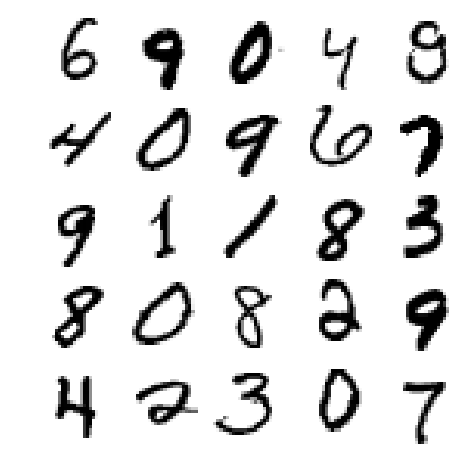

In [5]:
images, _ = next(iter(mnist_dataloader))
show_images(images, 25)

In [30]:
class Generator(nn.Module):
    def __init__(self, input_size, image_size=128, n_channels=3):
        super(Generator, self).__init__()
        
        self.input_size = input_size
        self.init_size = np.ceil(image_size / 8).astype(int)
        self.n_channels = n_channels
        self.output_size = image_size

        self.fc1 = nn.Sequential(
                    nn.Linear(self.input_size, 256),
                    nn.BatchNorm1d(256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, self.init_size * self.init_size * 512),
                    nn.LeakyReLU())
        
        self.trans_conv_block1 = nn.Sequential(
                    nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=1, padding=1, output_padding=0),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU(0.2)
        )
        
        self.trans_conv_block2 = nn.Sequential(
                    nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU(0.2)
        )
        
        self.trans_conv_block3 = nn.Sequential(
                    nn.ConvTranspose2d(128, self.n_channels, kernel_size=(4, 4), stride=2, padding=1, output_padding=0),
                    nn.BatchNorm2d(self.n_channels),
                    nn.Tanh()
        )
        
    def forward(self, z):
        hidden = self.fc1(z)
        hidden = hidden.view(-1, 512, self.init_size, self.init_size)
        hidden = self.trans_conv_block1(hidden)
        hidden = self.trans_conv_block2(hidden)
        hidden = self.trans_conv_block3(hidden)
        
        return hidden

In [25]:
class Discriminator(nn.Module):
    def __init__(self, image_size, n_channels=3):
        super(Discriminator, self).__init__()
        
        self.image_size = image_size
        self.fc_size = np.ceil(image_size / 4).astype(int)
        self.n_channels = n_channels
        
        self.conv_block1 = nn.Sequential(
                    nn.Conv2d(self.n_channels, 32, kernel_size=(5, 5), stride=2, padding=2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU(0.2)
                )
    
        self.conv_block2 = nn.Sequential(
                    nn.Conv2d(32, 64, kernel_size=(5, 5), stride=2, padding=2),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU(0.2)
                )
        
                
        self.conv_block3 = nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2, padding=2),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU(0.2)
                )
        
        self.fc1 = nn.Sequential(
                    nn.Linear(128 * self.fc_size * self.fc_size, 256),
                    nn.Linear(256, 1))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(-1, self.fc_size * self.fc_size * 128)
        x = self.fc1(x)

        return x

In [31]:
generator = Generator(100, image_size, n_channels=n_channels).to(device)
discriminator = Discriminator(image_size, n_channels=n_channels).to(device)
z = Variable(torch.cuda.FloatTensor(np.random.randn(images.shape[0], 100), device=device))
print(generator(z).shape)
discriminator(generator(z)).shape

torch.Size([128, 1, 17, 17])


RuntimeError: invalid argument 2: size '[-1 x 6272]' is invalid for input with 147456 elements at ..\aten\src\TH\THStorage.cpp:80

In [16]:
n_epochs = 100
generator_lr = 2e-4
discriminator_lr = 2e-4
image_size = 28
n_channels = 1

generator = Generator(100, image_size, n_channels=n_channels).to(device)
discriminator = Discriminator(image_size, n_channels=n_channels).to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=generator_lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr)

adversarial_loss = torch.nn.BCEWithLogitsLoss()

logger = Logger(f'mnist_dcgan_epochs{n_epochs}_g{generator_lr}_d{discriminator_lr}_batchsize{batch_size}',
                'Trying a smaller kernel size with G as well as a double FC layer in the front. Also, D is now stride 2 only. ')
logger.get_run_command()

'tensorboard --logdir=C:\\Users\\Jonathan\\Documents\\development\\gan/runs/mnist_dcgan_epochs100_g0.0002_d0.0002_batchsize128/Nov-12-2018-16h28m26s/ --host=127.0.0.1'

[Epoch 0 / 100] G_loss: 9.2866; D_loss: 0.0002


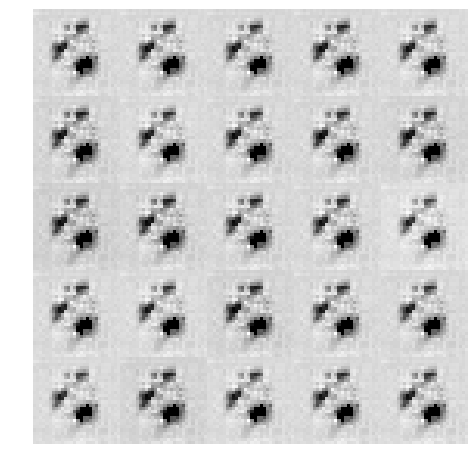

[Epoch 1 / 100] G_loss: 9.3700; D_loss: 0.0001


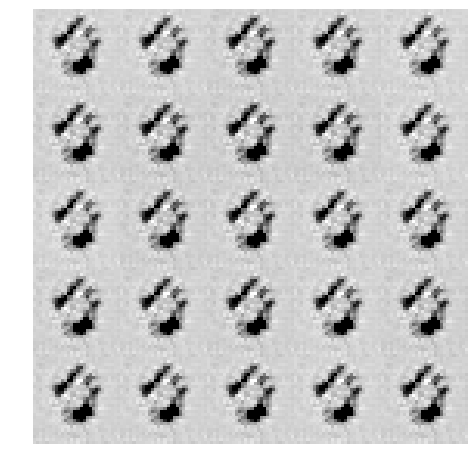

[Epoch 2 / 100] G_loss: 6.6793; D_loss: 0.0049


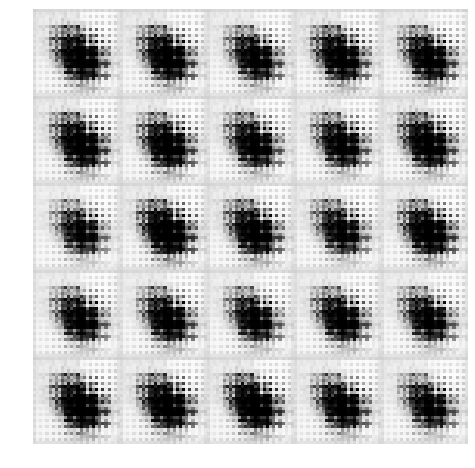

[Epoch 3 / 100] G_loss: 8.9211; D_loss: 0.0007


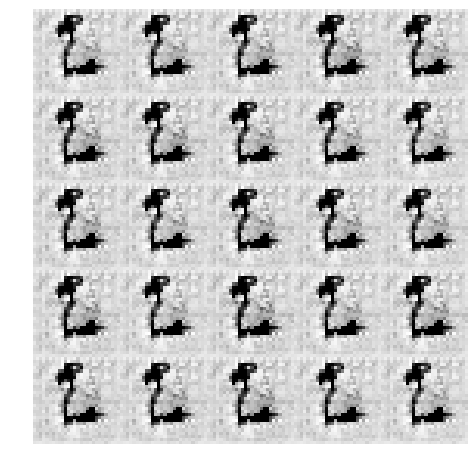

[Epoch 4 / 100] G_loss: 10.3522; D_loss: 0.0001


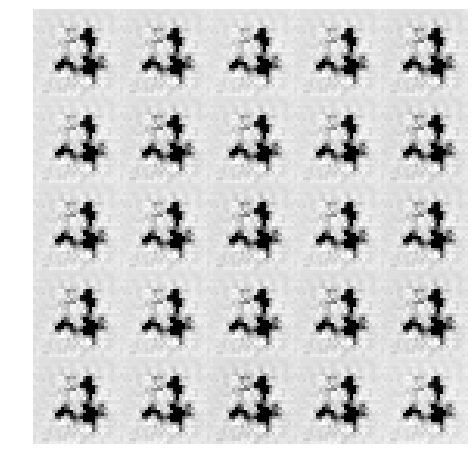

[Epoch 5 / 100] G_loss: 7.0106; D_loss: 0.0654


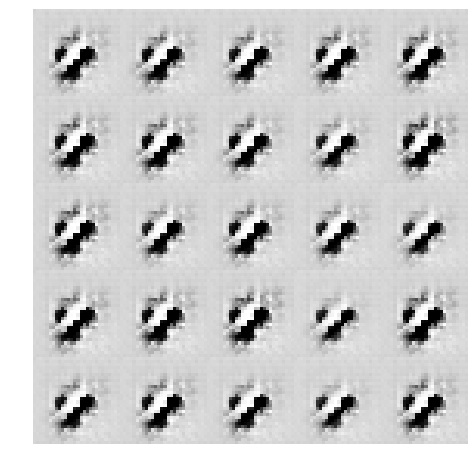

[Epoch 6 / 100] G_loss: 7.1303; D_loss: 0.0020


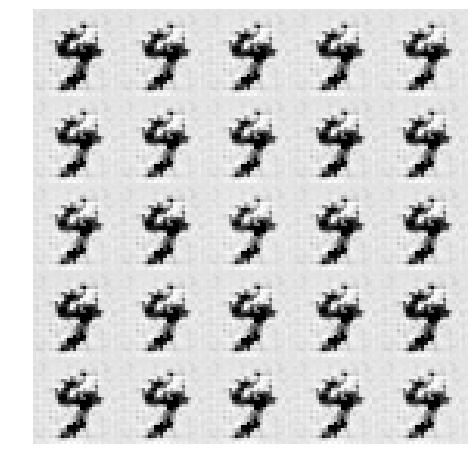

[Epoch 7 / 100] G_loss: 8.7531; D_loss: 0.0003


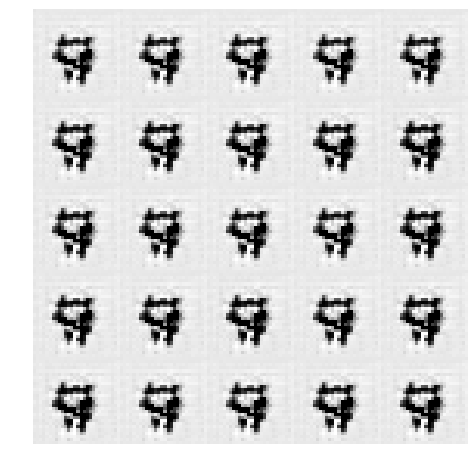

[Epoch 8 / 100] G_loss: 9.5074; D_loss: 0.0001


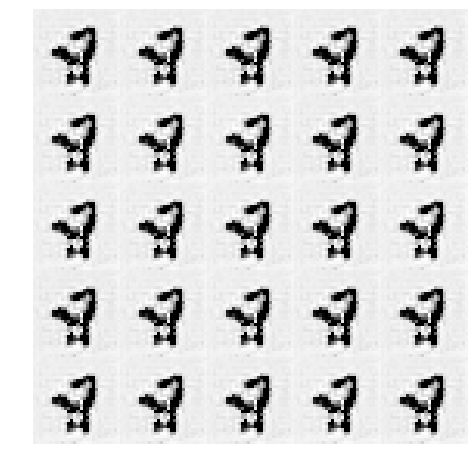

[Epoch 9 / 100] G_loss: 8.9601; D_loss: 0.0002


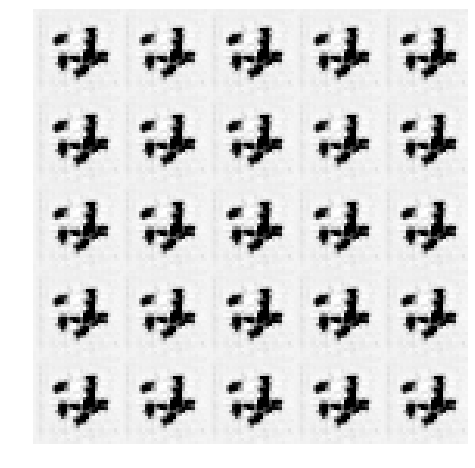

[Epoch 10 / 100] G_loss: 11.7255; D_loss: 0.0000


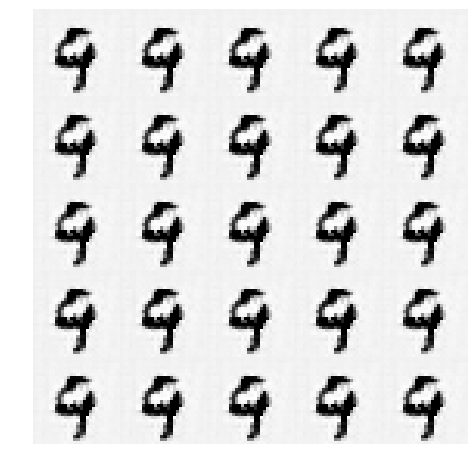

[Epoch 11 / 100] G_loss: 9.2492; D_loss: 0.0001


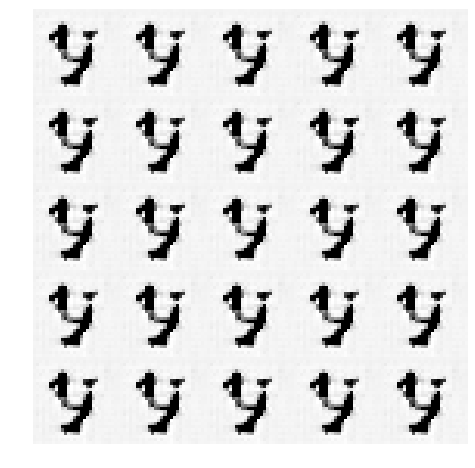

[Epoch 12 / 100] G_loss: 5.5802; D_loss: 0.0100


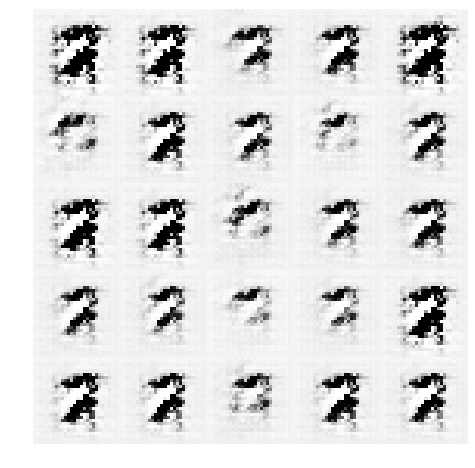

[Epoch 13 / 100] G_loss: 10.8106; D_loss: 0.0022


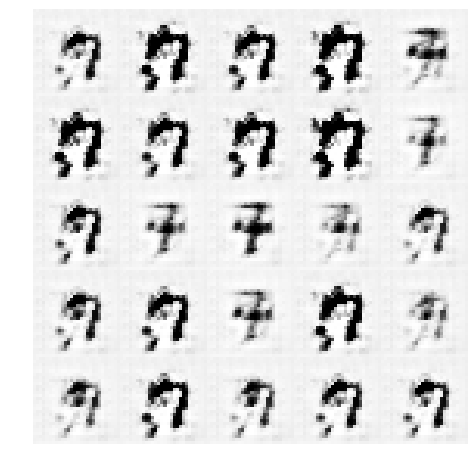

[Epoch 14 / 100] G_loss: 8.0381; D_loss: 0.0017


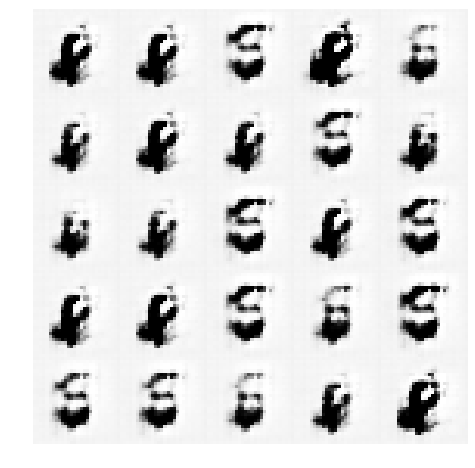

[Epoch 15 / 100] G_loss: 7.2301; D_loss: 0.0015


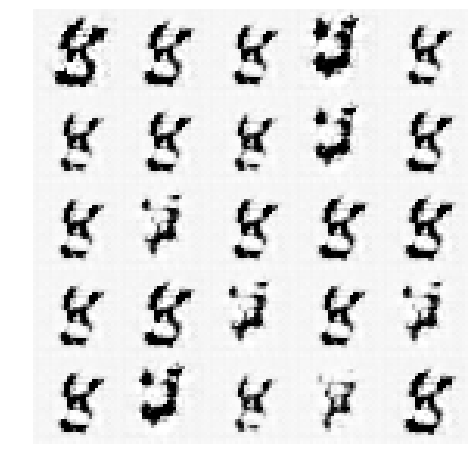

[Epoch 16 / 100] G_loss: 9.5296; D_loss: 0.0012


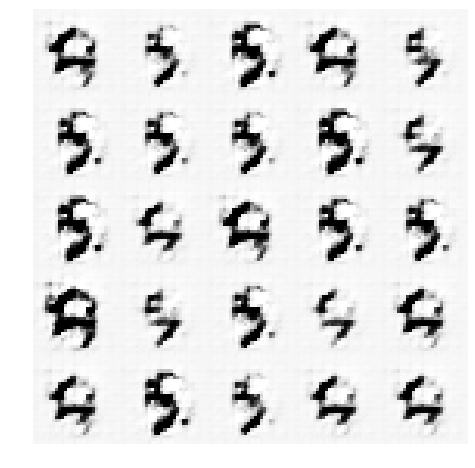

[Epoch 17 / 100] G_loss: 7.9989; D_loss: 0.0022


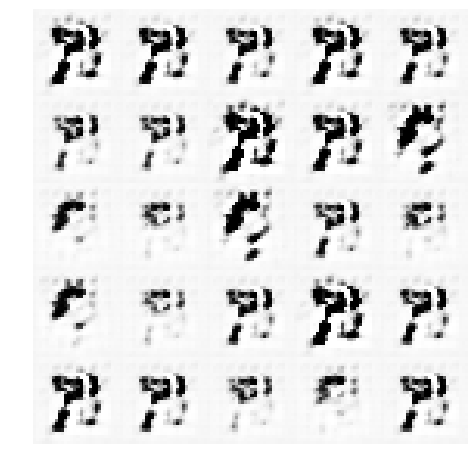

[Epoch 18 / 100] G_loss: 9.7084; D_loss: 0.0128


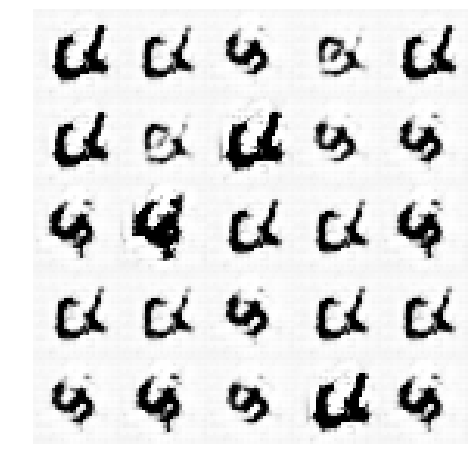

[Epoch 19 / 100] G_loss: 12.4183; D_loss: 0.0639


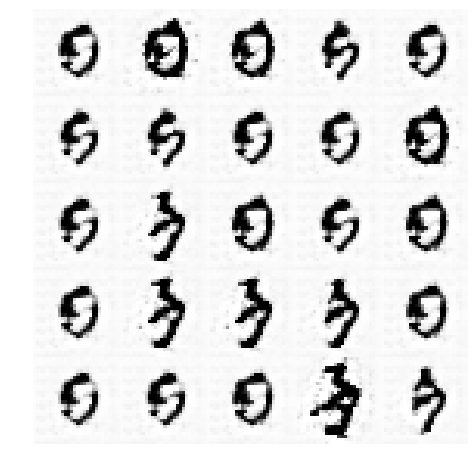

[Epoch 20 / 100] G_loss: 7.1830; D_loss: 0.0049


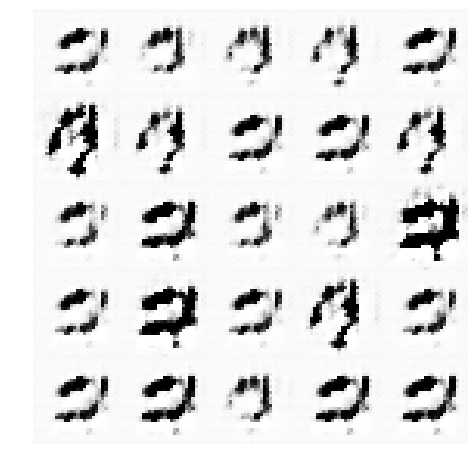

[Epoch 21 / 100] G_loss: 7.9216; D_loss: 0.0015


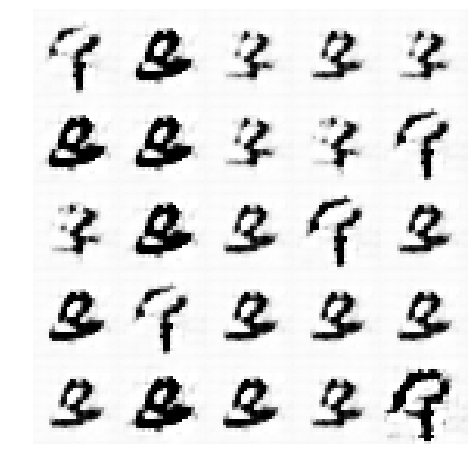

[Epoch 22 / 100] G_loss: 9.9550; D_loss: 0.0093


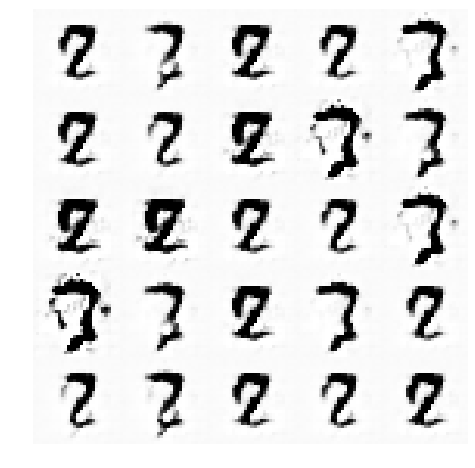

[Epoch 23 / 100] G_loss: 9.8994; D_loss: 0.0002


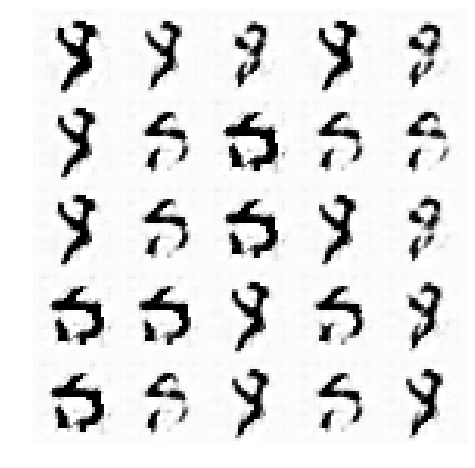

[Epoch 24 / 100] G_loss: 14.9832; D_loss: 0.0007


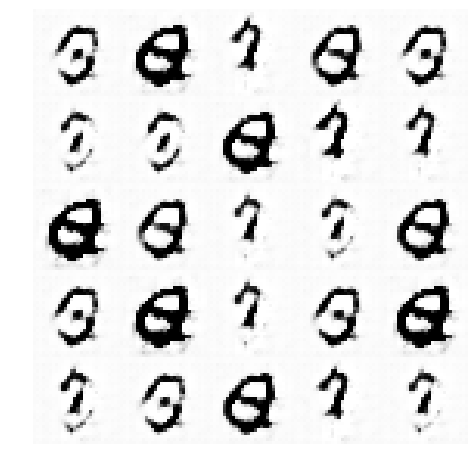

[Epoch 25 / 100] G_loss: 8.1456; D_loss: 0.0016


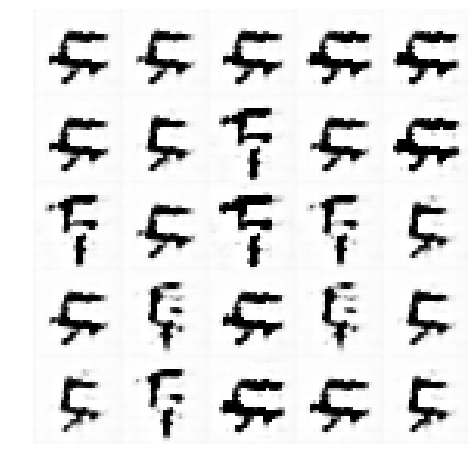

[Epoch 26 / 100] G_loss: 9.3069; D_loss: 0.0006


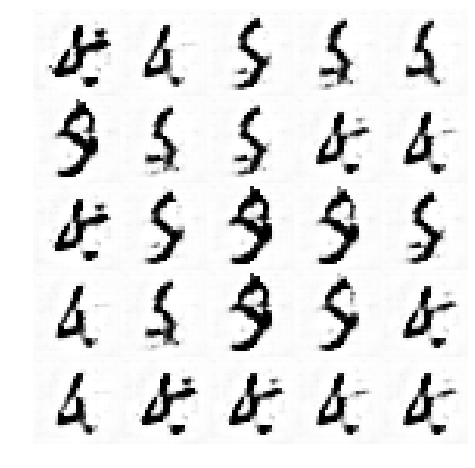

[Epoch 27 / 100] G_loss: 6.6869; D_loss: 0.0138


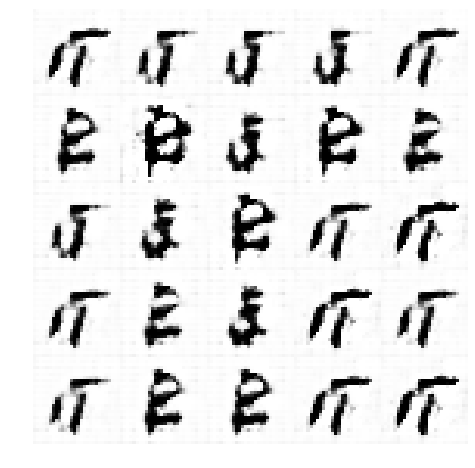

[Epoch 28 / 100] G_loss: 7.6900; D_loss: 0.0041


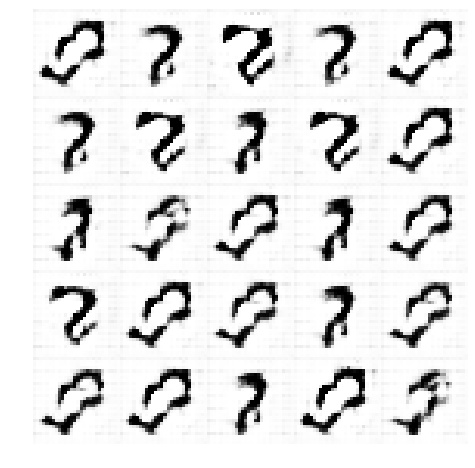

[Epoch 29 / 100] G_loss: 11.3641; D_loss: 0.0004


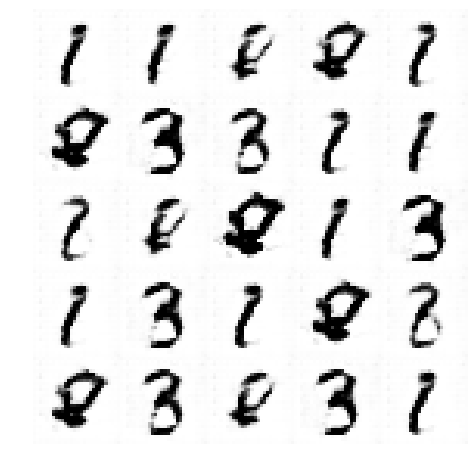

[Epoch 30 / 100] G_loss: 18.5766; D_loss: 0.0000


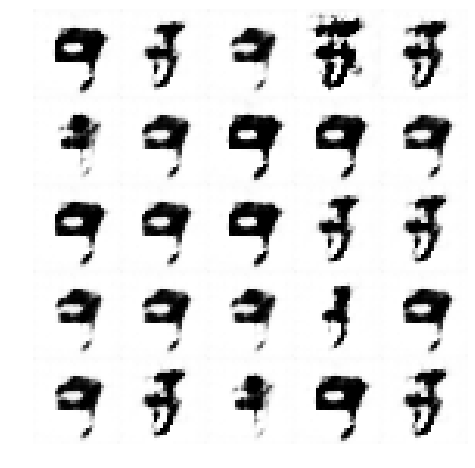

[Epoch 31 / 100] G_loss: 6.5361; D_loss: 0.0033


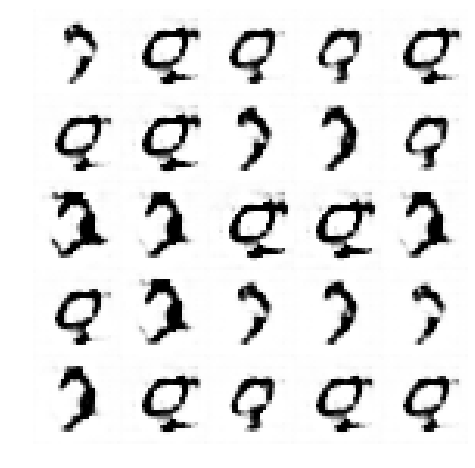

[Epoch 32 / 100] G_loss: 6.5968; D_loss: 0.0043


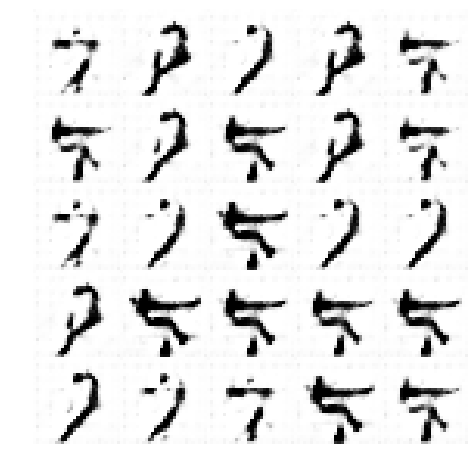

[Epoch 33 / 100] G_loss: 11.3172; D_loss: 0.1181


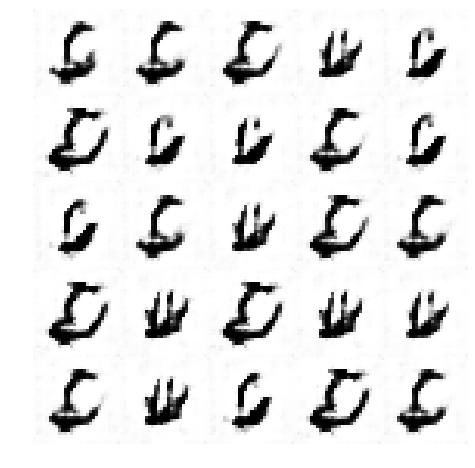

[Epoch 34 / 100] G_loss: 5.6749; D_loss: 0.0181


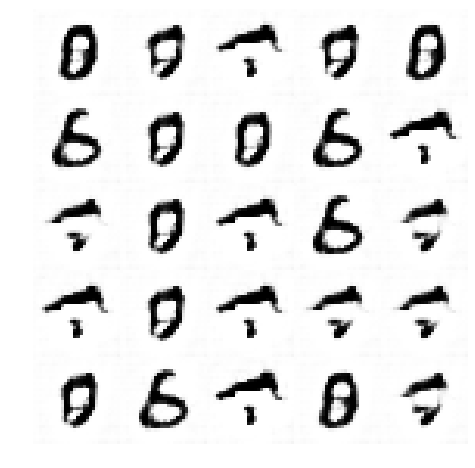

[Epoch 35 / 100] G_loss: 8.2898; D_loss: 0.0018


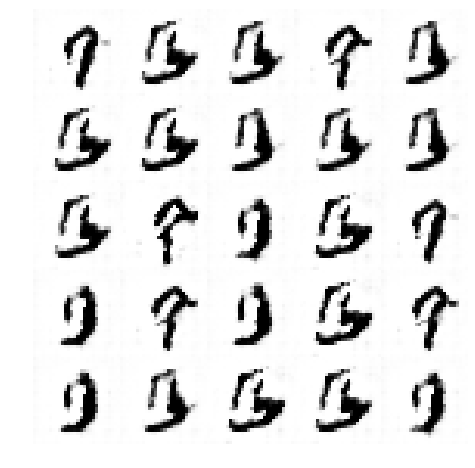

[Epoch 36 / 100] G_loss: 6.7824; D_loss: 0.0070


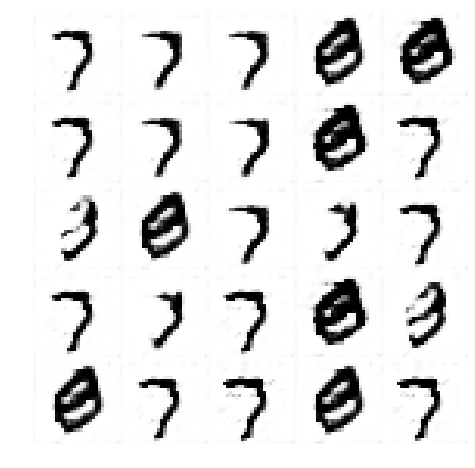

[Epoch 37 / 100] G_loss: 7.0475; D_loss: 0.0225


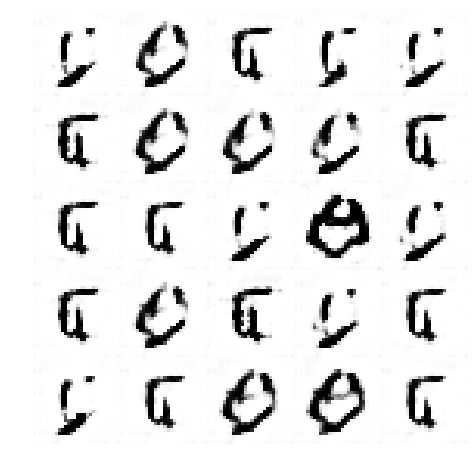

[Epoch 38 / 100] G_loss: 7.4590; D_loss: 0.0419


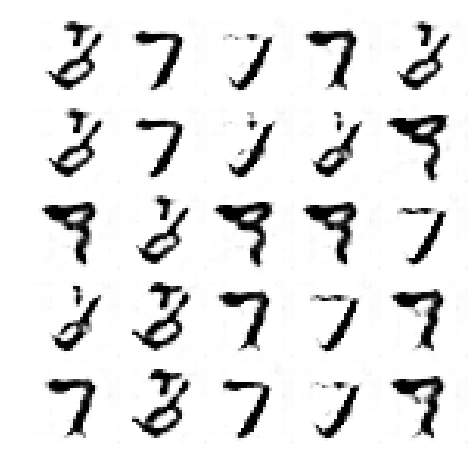

[Epoch 39 / 100] G_loss: 11.2815; D_loss: 0.0095


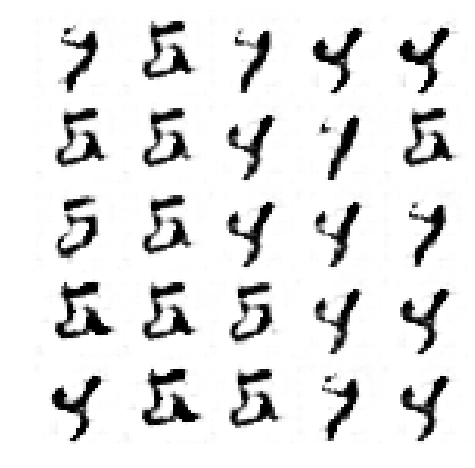

[Epoch 40 / 100] G_loss: 4.7099; D_loss: 0.0585


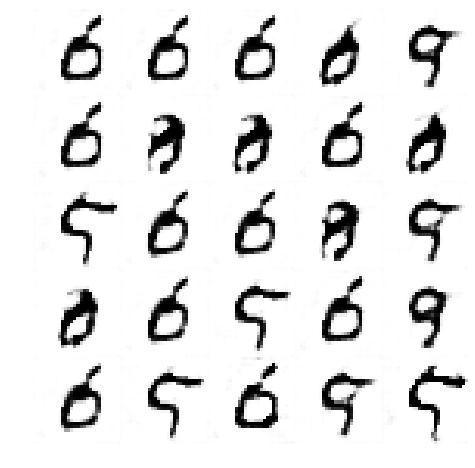

[Epoch 41 / 100] G_loss: 7.7995; D_loss: 0.0010


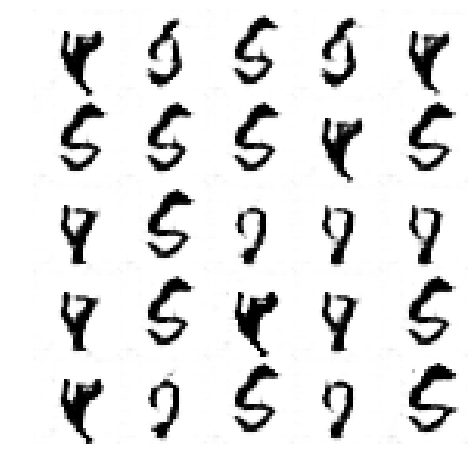

[Epoch 42 / 100] G_loss: 42.6437; D_loss: 0.2888


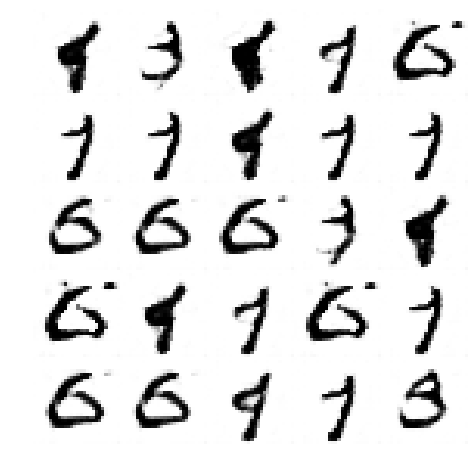

[Epoch 43 / 100] G_loss: 12.5617; D_loss: 0.0006


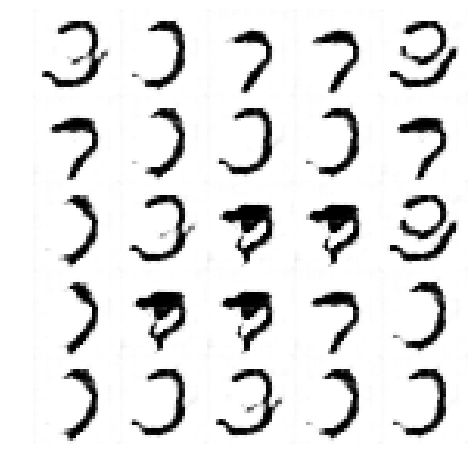

[Epoch 44 / 100] G_loss: 16.2581; D_loss: 0.0760


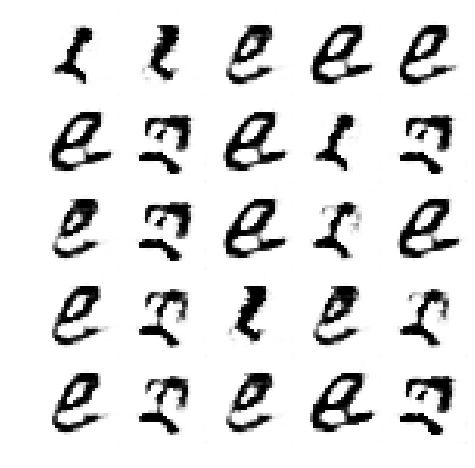

[Epoch 45 / 100] G_loss: 6.4703; D_loss: 0.0117


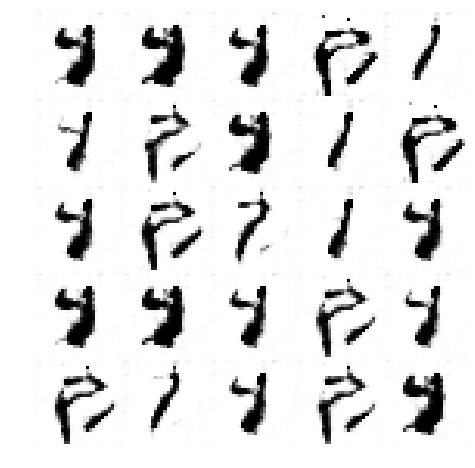

[Epoch 46 / 100] G_loss: 7.1748; D_loss: 0.0441


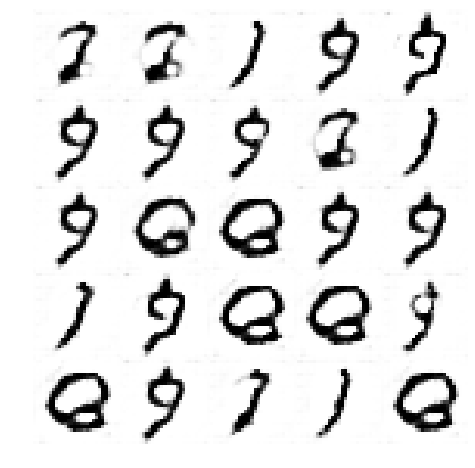

[Epoch 47 / 100] G_loss: 7.5674; D_loss: 0.0021


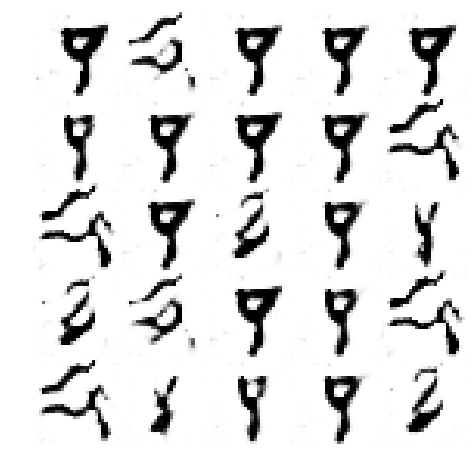

[Epoch 48 / 100] G_loss: 14.3960; D_loss: 0.0014


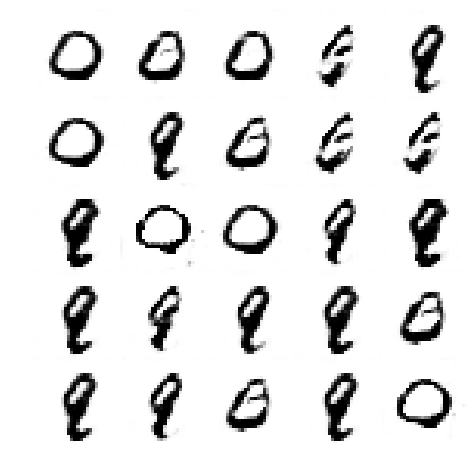

[Epoch 49 / 100] G_loss: 17.0019; D_loss: 0.0664


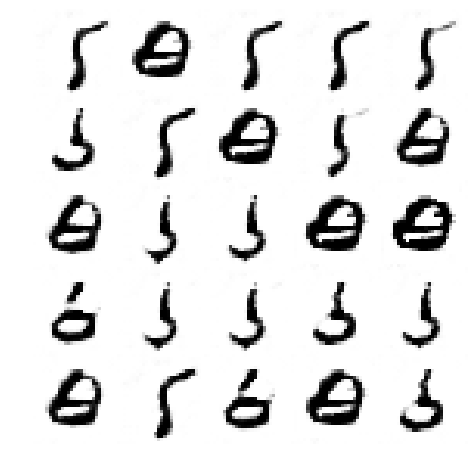

[Epoch 50 / 100] G_loss: 10.8890; D_loss: 0.0198


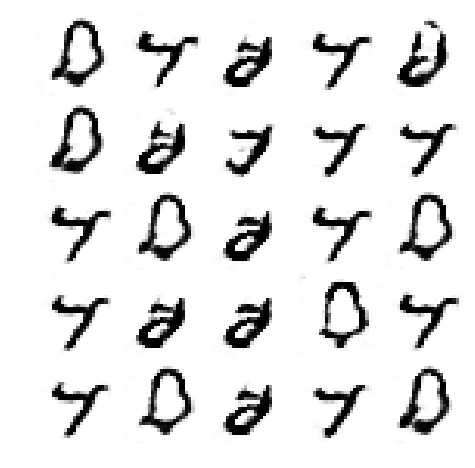

[Epoch 51 / 100] G_loss: 6.1638; D_loss: 0.0612


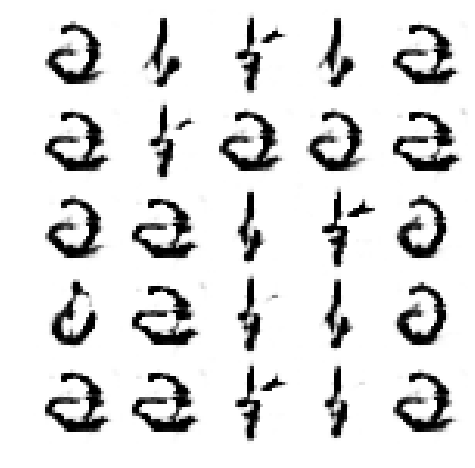

[Epoch 52 / 100] G_loss: 7.2730; D_loss: 0.0021


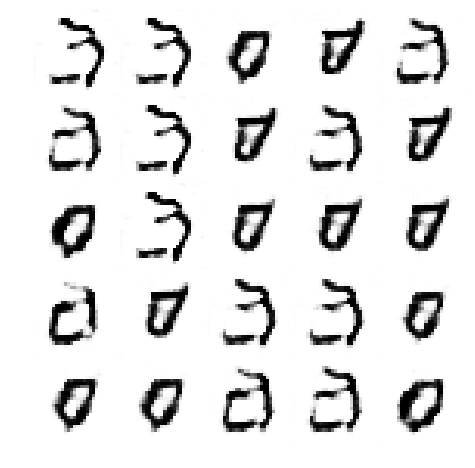

[Epoch 53 / 100] G_loss: 8.9579; D_loss: 0.0695


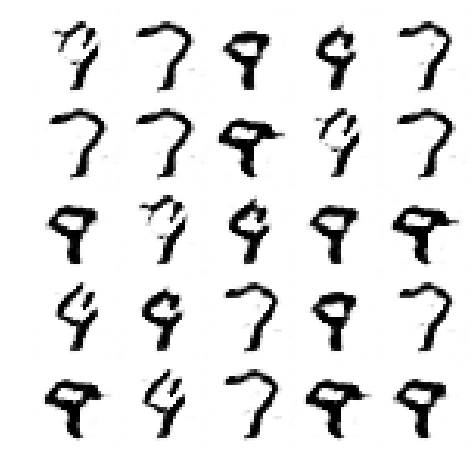

[Epoch 54 / 100] G_loss: 46.3108; D_loss: 0.0011


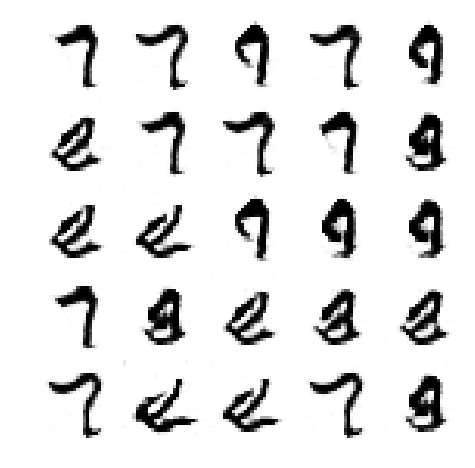

[Epoch 55 / 100] G_loss: 6.3164; D_loss: 0.0137


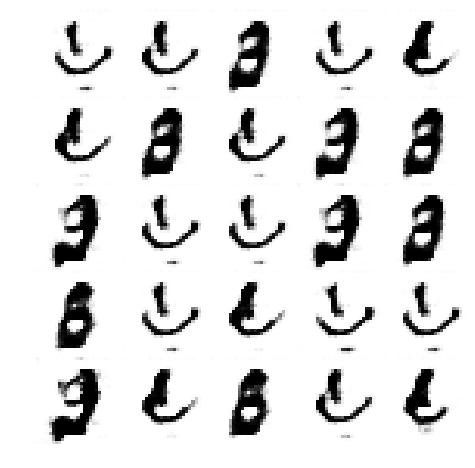

[Epoch 56 / 100] G_loss: 7.1257; D_loss: 0.0028


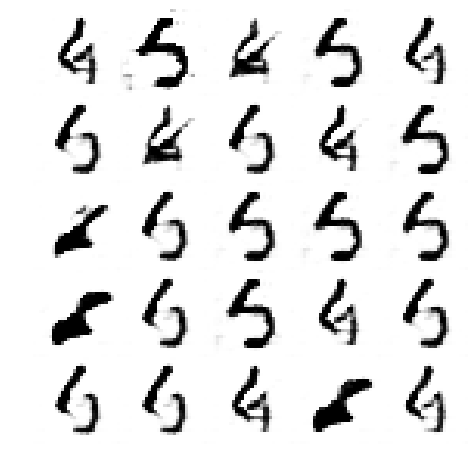

[Epoch 57 / 100] G_loss: 9.9917; D_loss: 0.0004


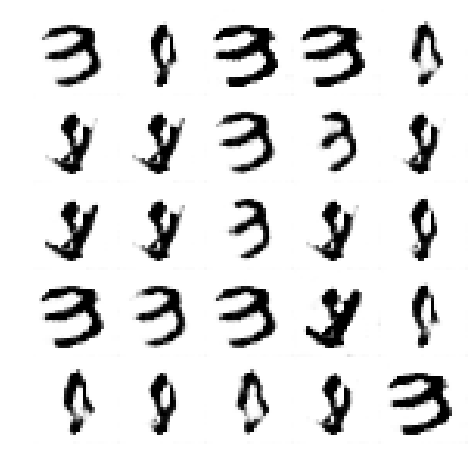

[Epoch 58 / 100] G_loss: 8.1791; D_loss: 0.0042


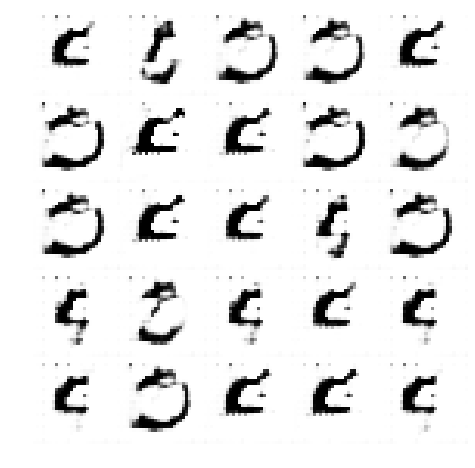

KeyboardInterrupt: 

In [17]:
for epoch in range(n_epochs):
    for images, _ in mnist_dataloader:
        images = images.to(device)
        real = Variable(torch.tensor([[1.]] * images.shape[0], device=device), requires_grad=False)        
        fake = Variable(torch.tensor([[0.]] * images.shape[0], device=device), requires_grad=False)
        
        optimizer_g.zero_grad()
        
        z = Variable(torch.cuda.FloatTensor(np.random.randn(images.shape[0], 100), device=device))
        generated_images = generator(z)
        gen_logits = discriminator(generated_images)
        g_loss = adversarial_loss(gen_logits, real)
        
        g_loss.backward()
        optimizer_g.step()
        
        optimizer_d.zero_grad()
        real_logits = discriminator(images)
        fake_logits = discriminator(generated_images.detach())

        d_loss = adversarial_loss(real_logits, real) + adversarial_loss(fake_logits, fake)
        d_loss.backward()
        optimizer_d.step()
        
        
        logger.log(g_loss, 'G_loss')        
        logger.log(d_loss, 'D_loss')        
        
        if logger.get_step() % 50 == 0:
            logger.log_image(generated_images.data, 'images', 16)
        logger.step()

    print(f'[Epoch {epoch} / {n_epochs}] G_loss: {g_loss:.4f}; D_loss: {d_loss:.4f}')
    show_images(generated_images, 25)